<a href="https://colab.research.google.com/github/sachin5nowal/ECG-Heartbeat-classification/blob/main/ECG_Heartbeat_classification_Part_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

In [ ]:
#@Introduction
"""
Title: Heart beat classification/Anomaly detection part-1
Date: May 10,2020.
Version:1.0
Submitted by: Sachin Nowal
"""

'\nTitle: Heart beat classification/Anomaly detection part-1\nDate: May 10,2020.\nVersion:1.0\nSubmitted by: Sachin Nowal\n'

# Loading all the important libraries

In [ ]:
#Checking whether GPU is attached and running with the notebook
!nvidia-smi

Wed May 20 01:15:16 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P0    35W / 250W |    557MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

# Installing and loading relevant libraries...

In [ ]:
print("Installing libraries...")
!pip install -qq arff2pandas
!pip install -q -U watermark

Installing libraries...


In [ ]:
print("Loading libraries...")
from tensorflow.keras.layers import GRU,LSTM,Dropout,RepeatVector,TimeDistributed,Dense
from tensorflow.keras import Sequential
from tensorflow.keras.utils import plot_model
# from imblearn.over_sampling import RandomOverSampler
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import tensorflow as tf
from arff2pandas import a2p
%matplotlib inline

RANDOM_SEED=42
np.random.seed(RANDOM_SEED)
import warnings
print("Done.")
warnings.filterwarnings('ignore')

Loading libraries...
Done.


# Dataset and problem statement


The dataset contains 5,000 Time Series examples (obtained with ECG) with 140 timesteps. Each sequence corresponds to a single heartbeat from a single patient with congestive heart failure.

An electrocardiogram (ECG or EKG) is a test that checks how your heart is functioning by measuring the electrical activity of the heart. With each heart beat, an electrical impulse (or wave) travels through your heart. This wave causes the muscle to squeeze and pump blood from the heart. Source

We have 5 types of hearbeats (classes):

Normal (N)
R-on-T Premature Ventricular Contraction (R-on-T PVC)
Premature Ventricular Contraction (PVC)
Supra-ventricular Premature or Ectopic Beat (SP or EB)
Unclassified Beat (UB).
Assuming a healthy heart and a typical rate of 70 to 75 beats per minute, each cardiac cycle, or heartbeat, takes about 0.8 seconds to complete the cycle. Frequency: 60–100 per minute (Humans) Duration: 0.6–1 second (Humans) Source

In [ ]:
;.data_folder_path="/content/drive/My Drive/drive_datasets/ecg_anomaly/ECG5000"

In [ ]:
with open(data_folder_path+'/ECG5000_TRAIN.arff') as f:
  train = a2p.load(f)

with open(data_folder_path+'/ECG5000_TEST.arff') as f:
  test = a2p.load(f)

In [ ]:
df = train.append(test)
df = df.sample(frac=1.0)
df.shape

(5000, 141)

In [ ]:
df.head()

,att1@NUMERIC,att2@NUMERIC,att3@NUMERIC,att4@NUMERIC,att5@NUMERIC,att6@NUMERIC,att7@NUMERIC,att8@NUMERIC,att9@NUMERIC,att10@NUMERIC,att11@NUMERIC,att12@NUMERIC,att13@NUMERIC,att14@NUMERIC,att15@NUMERIC,att16@NUMERIC,att17@NUMERIC,att18@NUMERIC,att19@NUMERIC,att20@NUMERIC,att21@NUMERIC,att22@NUMERIC,att23@NUMERIC,att24@NUMERIC,att25@NUMERIC,att26@NUMERIC,att27@NUMERIC,att28@NUMERIC,att29@NUMERIC,att30@NUMERIC,att31@NUMERIC,att32@NUMERIC,att33@NUMERIC,att34@NUMERIC,att35@NUMERIC,att36@NUMERIC,att37@NUMERIC,att38@NUMERIC,att39@NUMERIC,att40@NUMERIC,...,att102@NUMERIC,att103@NUMERIC,att104@NUMERIC,att105@NUMERIC,att106@NUMERIC,att107@NUMERIC,att108@NUMERIC,att109@NUMERIC,att110@NUMERIC,att111@NUMERIC,att112@NUMERIC,att113@NUMERIC,att114@NUMERIC,att115@NUMERIC,att116@NUMERIC,att117@NUMERIC,att118@NUMERIC,att119@NUMERIC,att120@NUMERIC,att121@NUMERIC,att122@NUMERIC,att123@NUMERIC,att124@NUMERIC,att125@NUMERIC,att126@NUMERIC,att127@NUMERIC,att128@NUMERIC,att129@NUMERIC,att130@NUMERIC,att131@NUMERIC,att132@NUMERIC,att133@NUMERIC,att134@NUMERIC,att135@NUMERIC,att136@NUMERIC,att137@NUMERIC,att138@NUMERIC,att139@NUMERIC,att140@NUMERIC,"target@{1,2,3,4,5}"
1001,1.469756,-1.048520,-3.394356,-4.254399,-4.162834,-3.822570,-3.003609,-1.799773,-1.500033,-1.025095,-0.166753,0.011275,-0.147008,-0.088714,-0.114587,-0.146307,-0.157915,-0.027796,-0.214186,-0.141600,-0.210829,-0.203778,-0.153019,-0.266533,-0.390077,-0.327032,-0.400833,-0.407830,-0.501358,-0.522868,-0.574155,-0.659348,-0.663703,-0.724858,-0.682038,-0.770026,-0.798246,-0.747866,-0.758533,-0.591910,...,1.487003,1.675518,1.836158,1.767251,1.735520,1.630994,1.380285,1.062822,0.829051,0.559157,0.189454,-0.083072,-0.387828,-0.484409,-0.490306,-0.518586,-0.419299,-0.440095,-0.357985,-0.486044,-0.486691,-0.376997,-0.444405,-0.295011,-0.381458,-0.357774,-0.308135,-0.068073,0.510416,0.873347,0.945178,1.275588,1.617218,1.580279,1.306195,1.351674,1.915517,1.672103,-1.039932,1
2086,-1.998602,-3.770552,-4.267091,-4.256133,-3.515288,-2.554540,-1.699639,-1.566366,-1.038815,-0.425483,-0.262474,-0.197361,-0.340497,-0.323774,-0.335513,-0.254583,-0.264334,-0.338740,-0.284649,-0.368613,-0.394213,-0.439726,-0.368993,-0.376742,-0.423022,-0.529464,-0.589248,-0.544008,-0.518129,-0.678544,-0.717577,-0.740041,-0.769233,-0.785213,-0.821685,-0.769256,-0.772686,-0.781586,-0.818404,-0.769080,...,1.780951,1.779466,1.754980,1.696125,1.596021,1.385371,1.189426,0.954776,0.739367,0.423573,0.085743,-0.030826,-0.042948,-0.122153,-0.101229,-0.135996,-0.093358,-0.113487,-0.118484,-0.088536,-0.020003,-0.029816,-0.044748,0.034468,0.070666,0.057764,0.120260,0.417549,0.799119,1.028602,1.008577,1.024698,1.051141,1.015352,0.988475,1.050191,1.089509,1.465382,0.799517,1
2153,-1.187772,-3.365038,-3.695653,-4.094781,-3.992549,-3.425381,-2.057643,-1.277729,-1.307397,-0.623098,-0.320708,-0.359462,-0.377039,-0.397033,-0.381755,-0.427911,-0.414237,-0.448439,-0.437101,-0.362470,-0.357754,-0.360832,-0.456013,-0.426373,-0.477425,-0.551853,-0.491515,-0.540644,-0.626111,-0.672909,-0.609645,-0.674574,-0.738285,-0.711991,-0.707088,-0.719290,-0.665765,-0.681393,-0.551106,-0.678160,...,1.539706,1.861135,1.823973,1.842621,1.807378,1.673375,1.435519,1.256942,1.141169,0.773353,0.352743,-0.006171,-0.082585,-0.174300,-0.050298,-0.190888,-0.151327,-0.106006,-0.101364,-0.116433,-0.127277,0.010743,-0.166507,-0.219952,-0.076155,-0.062330,0.009366,0.151061,0.459543,0.972686,1.085007,1.467196,1.413850,1.283822,0.923126,0.759235,0.932364,1.216265,-0.824489,1
555,0.604969,-1.671363,-3.236131,-3.966465,-4.067820,-3.551897,-2.582864,-1.804755,-1.688151,-1.025897,-0.434404,-0.391973,-0.488243,-0.431901,-0.389872,-0.552537,-0.522013,-0.412052,-0.435156,-0.485882,-0.495175,-0.472248,-0.491598,-0.542585,-0.495330,-0.514791,-0.556296,-0.654450,-0.652184,-0.705807,-0.764955,-0.806090,-0.826952,-0.834084,-0.824845,-0.894700,-0.855387,-0.843114,-0.803555,-0.649946,...,1.512614,1.786149,1.961367,1.853974,1.825461,1.679417,1.585913,1.286001,0.959101,0.604489,0.249181,-0.

In [ ]:
df.describe()

,att1@NUMERIC,att2@NUMERIC,att3@NUMERIC,att4@NUMERIC,att5@NUMERIC,att6@NUMERIC,att7@NUMERIC,att8@NUMERIC,att9@NUMERIC,att10@NUMERIC,att11@NUMERIC,att12@NUMERIC,att13@NUMERIC,att14@NUMERIC,att15@NUMERIC,att16@NUMERIC,att17@NUMERIC,att18@NUMERIC,att19@NUMERIC,att20@NUMERIC,att21@NUMERIC,att22@NUMERIC,att23@NUMERIC,att24@NUMERIC,att25@NUMERIC,att26@NUMERIC,att27@NUMERIC,att28@NUMERIC,att29@NUMERIC,att30@NUMERIC,att31@NUMERIC,att32@NUMERIC,att33@NUMERIC,att34@NUMERIC,att35@NUMERIC,att36@NUMERIC,att37@NUMERIC,att38@NUMERIC,att39@NUMERIC,att40@NUMERIC,...,att101@NUMERIC,att102@NUMERIC,att103@NUMERIC,att104@NUMERIC,att105@NUMERIC,att106@NUMERIC,att107@NUMERIC,att108@NUMERIC,att109@NUMERIC,att110@NUMERIC,att111@NUMERIC,att112@NUMERIC,att113@NUMERIC,att114@NUMERIC,att115@NUMERIC,att116@NUMERIC,att117@NUMERIC,att118@NUMERIC,att119@NUMERIC,att120@NUMERIC,att121@NUMERIC,att122@NUMERIC,att123@NUMERIC,att124@NUMERIC,att125@NUMERIC,att126@NUMERIC,att127@NUMERIC,att128@NUMERIC,att129@NUMERIC,att130@NUMERIC,att131@NUMERIC,att132@NUMERIC,att133@NUMERIC,att134@NUMERIC,att135@NUMERIC,att136@NUMERIC,att137@NUMERIC,att138@NUMERIC,att139@NUMERIC,att140@NUMERIC
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,...,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,-0.262476,-1.649511,-2.492211,-3.119443,-3.167438,-2.866308,-2.273126,-1.798127,-1.410124,-0.936082,-0.586326,-0.434430,-0.337621,-0.258235,-0.184443,-0.120015,-0.070396,-0.041849,-0.037049,-0.041243,-0.048908,-0.060176,-0.070725,-0.085491,-0.101144,-0.116070,-0.134461,-0.155811,-0.177542,-0.200685,-0.224244,-0.246686,-0.271476,-0.290321,-0.304461,-0.315111,-0.316851,-0.313070,-0.303238,-0.287315,...,0.946527,1.051337,1.138071,1.187551,1.201909,1.190866,1.154605,1.086347,0.986863,0.864419,0.720300,0.570000,0.428955,0.319734,0.242586,0.181059,0.134708,0.109781,0.093630,0.081028,0.065780,0.047326,0.025409,0.004531,-0.009790,-0.019087,-0.026208,-0.029561,0.000637,0.086588,0.146319,0.070973,-0.062914,-0.276206,-0.507667,-0.761043,-0.834741,-0.642263,-0.487242,-0.706008
std,1.152369,1.445493,1.386409,1.302802,1.104382,0.906133,0.731627,0.623100,0.637149,0.657945,0.592049,0.493606,0.426206,0.393553,0.382488,0.386315,0.400830,0.415267,0.423797,0.429734,0.434976,0.441768,0.447727,0.454600,0.461603,0.472726,0.483574,0.492048,0.503468,0.516169,0.530030,0.543061,0.552285,0.560649,0.564906,0.566459,0.560789,0.548964,0.536229,0.517508,...,0.520027,0.574633,0.614855,0.623050,0.608319,0.582721,0.553923,0.531272,0.507226,0.485600,0.483479,0.511334,0.546391,0.565580,0.571998,0.573798,0.584480,0.589680,0.591613,0.597117,0.603953,0.610288,0.619812,0.633101,0.649239,0.667657,0.680713,0.693871,0.751844,0.920052,1.171299,1.404842,1.646585,1.895134,2.059758,2.086218,2.056220,1.859296,1.830987,1.414465
min,-6.729499,-7.090374,-5.132459,-5.363241,-5.375715,-5.330194,-4.782240,-4.311288,-4.071361,-4.142476,-4.040526,-3.724538,-3.264576,-3.222345,-3.263484,-3.219212,-3.202187,-3.147504,-3.459917,-4.102102,-4.311241,-4.099888,-3.614973,-3.822298,-3.795567,-3.690817,-3.542485,-3.631665,-3.587112,-3.452215,-4.074752,-4.137454,-4.059662,-3.626646,-2.829471,-3.585866,-

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5000 entries, 1001 to 360
Columns: 141 entries, att1@NUMERIC to target@{1,2,3,4,5}
dtypes: float64(140), object(1)
memory usage: 5.4+ MB


# Exploring dataset



In [ ]:
class_dict ={'Normal':1,'R on T':2,'PVC':3,'SP':4,'UB':5}
class_names = ['Normal','R on T','PVC','SP','UB']
new_columns = list(df.columns)
new_columns[-1] = 'target'
df.columns = new_columns

In [ ]:
df.target.value_counts()

1    2919
2    1767
4     194
3      96
5      24
Name: target, dtype: int64

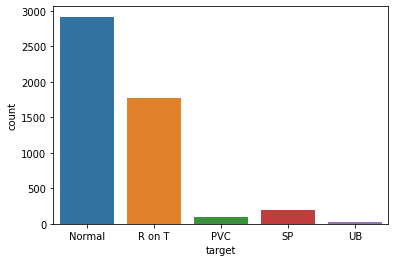

In [ ]:
ax = sns.countplot(df.target)
ax.set_xticklabels(class_names);

In [ ]:
def plot_time_series_class(data, class_name, ax, n_steps=10):
  time_series_df = pd.DataFrame(data)

  smooth_path = time_series_df.rolling(n_steps).mean()
  path_deviation = 2 * time_series_df.rolling(n_steps).std()

  under_line = (smooth_path - path_deviation)[0]
  over_line = (smooth_path + path_deviation)[0]

  ax.plot(smooth_path, linewidth=2)
  ax.fill_between(
    path_deviation.index,
    under_line,
    over_line,
    alpha=.125
  )
  ax.set_title(class_name)

In [ ]:
df

,att1@NUMERIC,att2@NUMERIC,att3@NUMERIC,att4@NUMERIC,att5@NUMERIC,att6@NUMERIC,att7@NUMERIC,att8@NUMERIC,att9@NUMERIC,att10@NUMERIC,att11@NUMERIC,att12@NUMERIC,att13@NUMERIC,att14@NUMERIC,att15@NUMERIC,att16@NUMERIC,att17@NUMERIC,att18@NUMERIC,att19@NUMERIC,att20@NUMERIC,att21@NUMERIC,att22@NUMERIC,att23@NUMERIC,att24@NUMERIC,att25@NUMERIC,att26@NUMERIC,att27@NUMERIC,att28@NUMERIC,att29@NUMERIC,att30@NUMERIC,att31@NUMERIC,att32@NUMERIC,att33@NUMERIC,att34@NUMERIC,att35@NUMERIC,att36@NUMERIC,att37@NUMERIC,att38@NUMERIC,att39@NUMERIC,att40@NUMERIC,...,att102@NUMERIC,att103@NUMERIC,att104@NUMERIC,att105@NUMERIC,att106@NUMERIC,att107@NUMERIC,att108@NUMERIC,att109@NUMERIC,att110@NUMERIC,att111@NUMERIC,att112@NUMERIC,att113@NUMERIC,att114@NUMERIC,att115@NUMERIC,att116@NUMERIC,att117@NUMERIC,att118@NUMERIC,att119@NUMERIC,att120@NUMERIC,att121@NUMERIC,att122@NUMERIC,att123@NUMERIC,att124@NUMERIC,att125@NUMERIC,att126@NUMERIC,att127@NUMERIC,att128@NUMERIC,att129@NUMERIC,att130@NUMERIC,att131@NUMERIC,att132@NUMERIC,att133@NUMERIC,att134@NUMERIC,att135@NUMERIC,att136@NUMERIC,att137@NUMERIC,att138@NUMERIC,att139@NUMERIC,att140@NUMERIC,target
1001,1.469756,-1.048520,-3.394356,-4.254399,-4.162834,-3.822570,-3.003609,-1.799773,-1.500033,-1.025095,-0.166753,0.011275,-0.147008,-0.088714,-0.114587,-0.146307,-0.157915,-0.027796,-0.214186,-0.141600,-0.210829,-0.203778,-0.153019,-0.266533,-0.390077,-0.327032,-0.400833,-0.407830,-0.501358,-0.522868,-0.574155,-0.659348,-0.663703,-0.724858,-0.682038,-0.770026,-0.798246,-0.747866,-0.758533,-0.591910,...,1.487003,1.675518,1.836158,1.767251,1.735520,1.630994,1.380285,1.062822,0.829051,0.559157,0.189454,-0.083072,-0.387828,-0.484409,-0.490306,-0.518586,-0.419299,-0.440095,-0.357985,-0.486044,-0.486691,-0.376997,-0.444405,-0.295011,-0.381458,-0.357774,-0.308135,-0.068073,0.510416,0.873347,0.945178,1.275588,1.617218,1.580279,1.306195,1.351674,1.915517,1.672103,-1.039932,1
2086,-1.998602,-3.770552,-4.267091,-4.256133,-3.515288,-2.554540,-1.699639,-1.566366,-1.038815,-0.425483,-0.262474,-0.197361,-0.340497,-0.323774,-0.335513,-0.254583,-0.264334,-0.338740,-0.284649,-0.368613,-0.394213,-0.439726,-0.368993,-0.376742,-0.423022,-0.529464,-0.589248,-0.544008,-0.518129,-0.678544,-0.717577,-0.740041,-0.769233,-0.785213,-0.821685,-0.769256,-0.772686,-0.781586,-0.818404,-0.769080,...,1.780951,1.779466,1.754980,1.696125,1.596021,1.385371,1.189426,0.954776,0.739367,0.423573,0.085743,-0.030826,-0.042948,-0.122153,-0.101229,-0.135996,-0.093358,-0.113487,-0.118484,-0.088536,-0.020003,-0.029816,-0.044748,0.034468,0.070666,0.057764,0.120260,0.417549,0.799119,1.028602,1.008577,1.024698,1.051141,1.015352,0.988475,1.050191,1.089509,1.465382,0.799517,1
2153,-1.187772,-3.365038,-3.695653,-4.094781,-3.992549,-3.425381,-2.057643,-1.277729,-1.307397,-0.623098,-0.320708,-0.359462,-0.377039,-0.397033,-0.381755,-0.427911,-0.414237,-0.448439,-0.437101,-0.362470,-0.357754,-0.360832,-0.456013,-0.426373,-0.477425,-0.551853,-0.491515,-0.540644,-0.626111,-0.672909,-0.609645,-0.674574,-0.738285,-0.711991,-0.707088,-0.719290,-0.665765,-0.681393,-0.551106,-0.678160,...,1.539706,1.861135,1.823973,1.842621,1.807378,1.673375,1.435519,1.256942,1.141169,0.773353,0.352743,-0.006171,-0.082585,-0.174300,-0.050298,-0.190888,-0.151327,-0.106006,-0.101364,-0.116433,-0.127277,0.010743,-0.166507,-0.219952,-0.076155,-0.062330,0.009366,0.151061,0.459543,0.972686,1.085007,1.467196,1.413850,1.283822,0.923126,0.759235,0.932364,1.216265,-0.824489,1
555,0.604969,-1.671363,-3.236131,-3.966465,-4.067820,-3.551897,-2.582864,-1.804755,-1.688151,-1.025897,-0.434404,-0.391973,-0.488243,-0.431901,-0.389872,-0.552537,-0.522013,-0.412052,-0.435156,-0.485882,-0.495175,-0.472248,-0.491598,-0.542585,-0.495330,-0.514791,-0.556296,-0.654450,-0.652184,-0.705807,-0.764955,-0.806090,-0.826952,-0.834084,-0.824845,-0.894700,-0.855387,-0.843114,-0.803555,-0.649946,...,1.512614,1.786149,1.961367,1.853974,1.825461,1.679417,1.585913,1.286001,0.959101,0.604489,0.249181,-0.116396,-0.2304

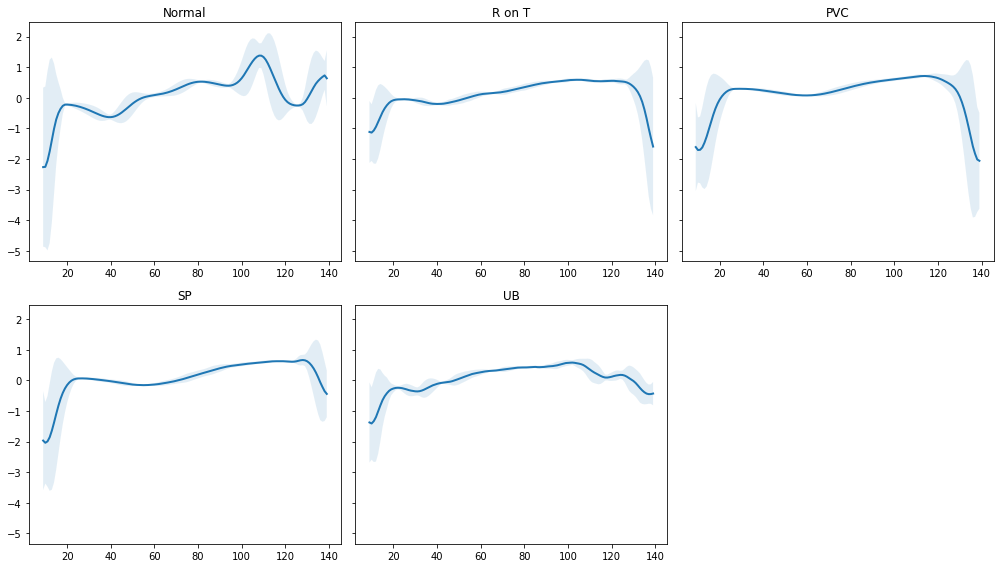

In [ ]:
classes = df['target'].unique()

fig, axs = plt.subplots(
  nrows=len(classes) // 3 + 1,
  ncols=3,
  sharey=True,
  figsize=(14, 8)
)

for i, cls in enumerate(classes):
  ax = axs.flat[i]
  data = df[df.target == cls] \
    .drop(labels='target', axis=1) \
    .mean(axis=0) \
    .to_numpy()
  plot_time_series_class(data, class_names[i], ax)

fig.delaxes(axs.flat[-1])
fig.tight_layout();

In [ ]:
df_temp=df.copy()

# Preparing input data for tensorflow model

In [ ]:
df['target'].replace({'4':'3','5':'3'},inplace=True)

In [ ]:
df=df.sample(frac=1)
X=df.drop(['target'],axis=1)
y=df[['target']]
from sklearn.model_selection import train_test_split
X_train_df, X_val_df, y_train_df, y_val_df = train_test_split(X, y, test_size = 0.15, random_state = RANDOM_SEED ,stratify = y)
X_test_df, X_val_df, y_test_df, y_val_df = train_test_split(X_val_df, y_val_df, test_size = 0.33, random_state = RANDOM_SEED ,stratify = y_val_df)

In [ ]:
df['target'].value_counts()

1    2919
2    1767
3     314
Name: target, dtype: int64

In [ ]:
max_size = y_train_df['target'].value_counts().max()
X_train_df['target']=y_train_df['target']
lst = [X_train_df]
for class_index, group in X_train_df.groupby('target'):
    lst.append(group.sample(max_size-len(group), replace=True))
X_train_df = pd.concat(lst)
del y_train_df
y_train_df=pd.DataFrame({'target':X_train_df['target']})
X_train_df.drop(['target'],axis=1,inplace=True)

In [ ]:
y_train_df['target'].value_counts()

2    2481
3    2481
1    2481
Name: target, dtype: int64

In [ ]:
# Functions for creating train , test and validation dataset prepartion
def one_hot_y(num):
  if(num>=1 and num<=3):
    num_lis=[0,0,0]
    num_lis[num-1]=1
    return num_lis
  else:
    # print("Error")
    ValueError("Error")

def transpose_func(X,y):
  X=tf.transpose(X)
  return X,y

def create_dataset(X,y):

  X_dataset=[[list(row[1])] for row in X.iterrows()]
  n_features=len(X_dataset[0])
  y_dataset=[one_hot_y(int(val)) for val in y['target']]

  dataset = tf.data.Dataset.from_tensor_slices((X_dataset,y_dataset))
  dataset=dataset.map(transpose_func)
  dataset=dataset.batch(8, drop_remainder=True)
  return dataset

In [ ]:
# Creating training, test and validation dataset
train_dataset = create_dataset(X_train_df,y_train_df)
val_dataset = create_dataset(X_val_df,y_val_df)
test_dataset = create_dataset(X_test_df,y_test_df)

In [ ]:
# Inspecting train dataset
train_dataset.take(2)

<TakeDataset shapes: ((8, 140, 1), (8, 3)), types: (tf.float32, tf.int32)>

# Building model architecture and training model

In [ ]:
# Building and compiling model
sequential_unit='GRU'
def create_model(seq_unit='LSTM'):
  model = Sequential()
  if(seq_unit=='LSTM'):
    model.add(LSTM(
        units=64,
        input_shape=(140,1),
        return_state=False,
        return_sequences=False
        ))
  elif(seq_unit=='GRU'):
    model.add(GRU(
        units=64,
        input_shape=(140,1),
        return_state=False,
        return_sequences=False
        ))
  else:
    print("Error: This mode/sequential unit is not supported")
  model.add(Dense(10))
  model.add(Dense(3,activation='softmax'))
  loss_fn=tf.keras.losses.CategoricalCrossentropy()
  model.compile(loss=loss_fn,  optimizer=tf.keras.optimizers.Adam(),  metrics=['accuracy'])
  return model
model=create_model(seq_unit=sequential_unit)


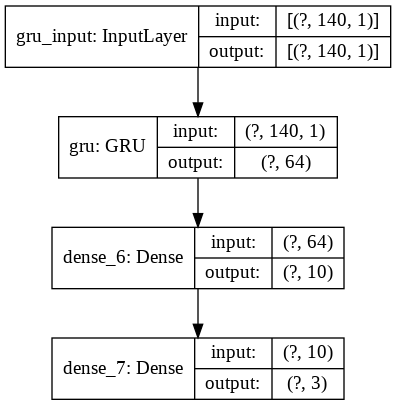

In [ ]:
#Plotting model architecture
plot_model(model, 'first_LSTM_model.png',show_shapes=True)

In [ ]:
#Training model architecture
History=model.fit(train_dataset,validation_data=val_dataset, epochs=10)

Epoch 1/10
930/930 [==============================] - 7s 8ms/step - loss: 0.2408 - accuracy: 0.9312 - val_loss: 11.0203 - val_accuracy: 0.0605
Epoch 2/10
930/930 [==============================] - 7s 7ms/step - loss: 0.3600 - accuracy: 0.9151 - val_loss: 5.8735 - val_accuracy: 0.0605
Epoch 3/10
930/930 [==============================] - 7s 7ms/step - loss: 0.2455 - accuracy: 0.9281 - val_loss: 5.8262 - val_accuracy: 0.0605
Epoch 4/10
930/930 [==============================] - 7s 7ms/step - loss: 0.2257 - accuracy: 0.9323 - val_loss: 5.3273 - val_accuracy: 0.0605
Epoch 5/10
930/930 [==============================] - 7s 7ms/step - loss: 0.2191 - accuracy: 0.9298 - val_loss: 4.8059 - val_accuracy: 0.0605
Epoch 6/10
930/930 [==============================] - 7s 7ms/step - loss: 0.2094 - accuracy: 0.9310 - val_loss: 5.3739 - val_accuracy: 0.0605
Epoch 7/10
930/930 [==============================] - 7s 7ms/step - loss: 0.2080 - accuracy: 0.9317 - val_loss: 5.8249 - val_accuracy: 0.0605
Epoch

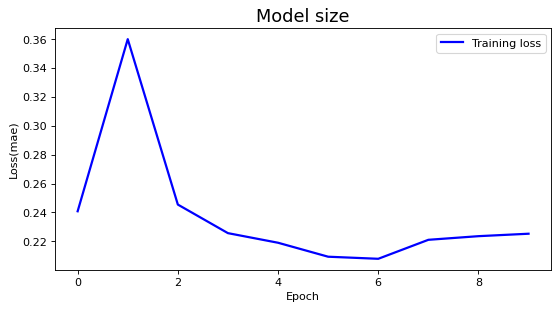

In [ ]:
#Plotting training metrics
#plt with training loss
history=History.history
fig, ax = plt.subplots(figsize=(8,4),dpi=80)
ax.plot(history['loss'],'b',label='Train',linewidth=2)
# ax.plot(history['val_loss'],'r',label='Validation',linewidth=2)
ax.set_title('Model size',fontsize=16)
ax.set_ylabel('Loss(mae)')
ax.set_xlabel('Epoch')
ax.legend(['Training loss'],loc='upper right')
plt.show()

# Testing and confusion matrix and comparison of different models

In [ ]:
y_proba=model.predict(test_dataset)
y_pred = y_proba.argmax(axis=-1)
y_true=np.array(y_test_df['target'][:len(pred)].astype(int))

In [ ]:
pred

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,

In [ ]:
from sklearn.metrics import accuracy_score,classification_report
acc=accuracy_score(y_test_df['target'][:len(pred)].astype(int),pred)

In [ ]:
acc

0.35080645161290325

In [ ]:
model.evaluate(test_dataset)

62/62 [==============================] - 0s 5ms/step - loss: 5.0073 - accuracy: 0.0645


[5.007267475128174, 0.06451612710952759]

In [ ]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           1       0.00      0.00      0.00       290
           2       0.35      1.00      0.52       174
           3       0.00      0.00      0.00        32

    accuracy                           0.35       496
   macro avg       0.12      0.33      0.17       496
weighted avg       0.12      0.35      0.18       496



In [ ]:
y_test_df['target'].value_counts()

1    293
2    177
3     32
Name: target, dtype: int64